In [1]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

In [2]:
# number of samples per components
n_samples = 500

In [3]:
np.random.seed(0)
C = np.array([[0., -0.1],[1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples,2),C),.7 * np.random.randn(n_samples,2) + np.array([-6,3])]

In [4]:
# fit a Gaussian Mixture Model with EM using five components
gmm = mixture.GaussianMixture(n_components=5,covariance_type='full').fit(X)

In [5]:
# fit a Dirichlet Process Gaussian Mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,covariance_type='full').fit(X)

Text(0.5,1,'DP-GMM')

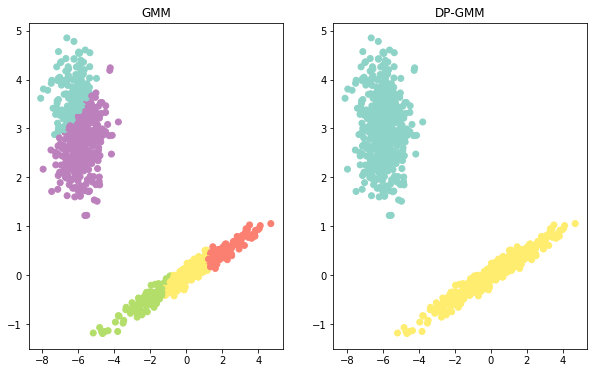

In [6]:
gmm_pred = gmm.predict(X)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],c = gmm_pred, cmap = 'Set3')
plt.title('GMM')

dpgmm_pred = dpgmm.predict(X)
plt.subplot(1,2,2)
plt.scatter(X[:,0],X[:,1],c = dpgmm_pred, cmap = 'Set3')
plt.title('DP-GMM')

In [16]:
# copy the top clusters of DP-GMM and fit the GMM model

# top clusters from DP-GMM
dpgmm_weight_truncated = dpgmm.weights_
dpgmm_weight_mask = dpgmm.weights_ > .1
dpgmm_weight_truncated[~dpgmm_weight_mask] = 0
dpgmm_weight_truncated /= np.sum(dpgmm_weight_truncated)
dpgmm_num_top_clusters = np.sum(dpgmm_weight_mask)

# get parameters from DP-GMM
_, _, dpgmm_means, _, dpgmm_covariances, dpgmm_precisions_chol = dpgmm._get_parameters()

# fit GMM models
gmm_using_top_dpgmm_clusters = mixture.GaussianMixture(n_components=dpgmm_num_top_clusters,
                                                       covariance_type= 'full').fit(X)
gmm_using_top_dpgmm_clusters._set_parameters((dpgmm_weight_truncated[dpgmm_weight_mask],
                                             dpgmm_means[dpgmm_weight_mask],
                                             dpgmm_covariances[dpgmm_weight_mask],
                                             dpgmm_precisions_chol[dpgmm_weight_mask]))

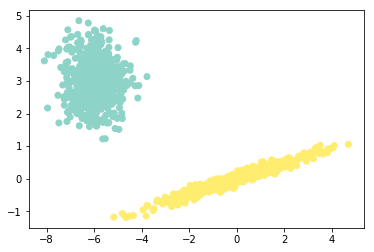

In [17]:
dpgmm_top_clusters_assignment = gmm_using_top_dpgmm_clusters.predict(X)
plt.scatter(X[:,0],X[:,1],c = dpgmm_top_clusters_assignment,cmap = 'Set3')

In [69]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
# plt the result 
def plot_result(X,Y_,means,covariance, index, title):
    splot = plt.subplot(2,1,1+index)
    for i, (mean,covar,color) in enumerate(zip(means,covariance,color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] /linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_==i, 0], X[Y_ == i, 1], .8, color = color)
        
        
        # plot an ellipse to show Gaussina component
        angle = np.arctan(u[1]/u[0])
        angle = 180. * angle/np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color = color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-9.,5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    
    plt.title(title)

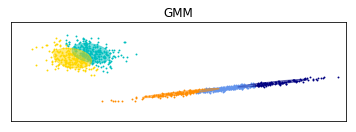

In [70]:
plot_result(X,gmm_pred,gmm.means_,gmm.covariances_,0,'GMM')